adapt from https://github.com/LSSTDESC/transient-host-sims/blob/main/notebooks/SCOTCH_walkthroughs.ipynb
and https://github.com/LSSTDESC/transient-host-sims/blob/main/notebooks/pzflow_DC2_conditionalFlow_finalCut.ipynb
and https://jfcrenshaw.github.io/pzflow/tutorials/intro/

In [1]:
# import jax
# jax.default_backend()
# import os
# os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [2]:
import pandas as pd
import numpy as np
import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling
# from pzflow.examples import galaxy_data
from pzflow.distributions import Uniform, Joint, Normal
import matplotlib.pyplot as plt

In [8]:
globalhostdata = pd.read_csv('ztfsniadr2/tables/globalhost_data.csv')
localhostdata = pd.read_csv('ztfsniadr2/tables/localhost_data.csv')
sndata = pd.read_csv('ztfsniadr2/tables/snia_data.csv')

In [9]:
globalhostdata.head()

,ztfname,ra_host,dec_host,mass,mass_err,restframe_gz,restframe_gz_err,d_dlr
0,ZTF17aadlxmv,127.448161,33.906468,10.424,0.116619,1.061697,0.018439,0.083759
1,ZTF18aaadqua,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ZTF18aaanzph,157.746954,23.788548,10.996,0.123223,1.351697,0.018439,1.698443
3,ZTF18aaapivw,102.564481,27.141323,8.515,0.103325,0.591697,0.046861,2.969719
4,ZTF18aaaqexr,175.776562,15.566957,10.774,0.117661,1.211697,0.018439,0.102694


In [10]:
localhostdata.head()

,ztfname,mass,mass_err,restframe_gz,restframe_gz_err
0,ZTF17aadlxmv,10.001,0.025,1.218697,0.017029
1,ZTF18aaadqua,6.743,0.344,0.321697,1.289935
2,ZTF18aaanzph,8.344,0.168,1.287697,0.500016
3,ZTF18aaapivw,7.507,0.092,0.607697,0.336146
4,ZTF18aaaqexr,10.727,0.065,1.313697,0.017692


In [11]:
sndata.head()

,Unnamed: 0,ztfname,redshift,redshift_err,source,t0,x0,x1,c,t0_err,...,mwebv_err,fitprob,ra,dec,sn_type,sub_type,lccoverage_flag,fitquality_flag,iau_name,frac_fitted
0,0,ZTF17aadlxmv,0.062019,0.000013,z_gal,58878.085277,0.001126,0.459966,0.062074,0.219280,...,0.0,0.178353,127.448018,33.906536,snia-cosmo,norm,1.0,1.0,2020adv,100.0
1,1,ZTF18aaadqua,0.078672,0.002807,z_snid,58130.778798,0.000845,4.999999,-0.392734,14.743977,...,0.0,0.127972,26.798708,18.798611,snia-pec,03fg,0.0,0.0,2018lq,100.0
2,2,ZTF18aaanzph,0.063718,0.000016,z_gal,58138.014461,0.000275,-1.224903,0.567260,8.873835,...,0.0,0.576895,157.743465,23.788356,snia-cosmo,norm,0.0,0.0,2018kc,100.0
3,3,ZTF18aaapivw,0.026341,0.004328,z_snid,58152.873526,0.001008,-4.999998,0.660968,0.971755,...,0.0,0.249074,102.563278,27.140073,snia-cosmo,norm,0.0,0.0,2018xi,100.0
4,4,ZTF18aaaqexr,0.070258,0.000022,z_gal,58893.687923,0.000610,-1.437246,0.048229,0.170907,...,0.0,0.038322,175.776516,15.567129,snia,NaN,1.0,1.0,2020chl,100.0


In [12]:
data = pd.merge(sndata,globalhostdata,on='ztfname')
data.head()

,Unnamed: 0,ztfname,redshift,redshift_err,source,t0,x0,x1,c,t0_err,...,fitquality_flag,iau_name,frac_fitted,ra_host,dec_host,mass,mass_err,restframe_gz,restframe_gz_err,d_dlr
0,0,ZTF17aadlxmv,0.062019,0.000013,z_gal,58878.085277,0.001126,0.459966,0.062074,0.219280,...,1.0,2020adv,100.0,127.448161,33.906468,10.424,0.116619,1.061697,0.018439,0.083759
1,1,ZTF18aaadqua,0.078672,0.002807,z_snid,58130.778798,0.000845,4.999999,-0.392734,14.743977,...,0.0,2018lq,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,ZTF18aaanzph,0.063718,0.000016,z_gal,58138.014461,0.000275,-1.224903,0.567260,8.873835,...,0.0,2018kc,100.0,157.746954,23.788548,10.996,0.123223,1.351697,0.018439,1.698443
3,3,ZTF18aaapivw,0.026341,0.004328,z_snid,58152.873526,0.001008,-4.999998,0.660968,0.971755,...,0.0,2018xi,100.0,102.564481,27.141323,8.515,0.103325,0.591697,0.046861,2.969719
4,4,ZTF18aaaqexr,0.070258,0.000022,z_gal,58893.687923,0.000610,-1.437246,0.048229,0.170907,...,1.0,2020chl,100.0,175.776562,15.566957,10.774,0.117661,1.211697,0.018439,0.102694


In [13]:
data.columns

Index(['Unnamed: 0', 'ztfname', 'redshift', 'redshift_err', 'source', 't0',
       'x0', 'x1', 'c', 't0_err', 'x0_err', 'x1_err', 'c_err', 'cov_t0_x0',
       'cov_t0_x1', 'cov_t0_c', 'cov_x0_x1', 'cov_x0_c', 'cov_x1_c', 'mwebv',
       'mwr_v', 'mwebv_err', 'fitprob', 'ra', 'dec', 'sn_type', 'sub_type',
       'lccoverage_flag', 'fitquality_flag', 'iau_name', 'frac_fitted',
       'ra_host', 'dec_host', 'mass', 'mass_err', 'restframe_gz',
       'restframe_gz_err', 'd_dlr'],
      dtype='object')

In [25]:
data_train = data[['mass','restframe_gz','redshift','x1','c']]
data_train

,mass,restframe_gz,redshift,x1,c
0,10.424,1.061697,0.062019,0.459966,0.062074
1,NaN,NaN,0.078672,4.999999,-0.392734
2,10.996,1.351697,0.063718,-1.224903,0.567260
3,8.515,0.591697,0.026341,-4.999998,0.660968
4,10.774,1.211697,0.070258,-1.437246,0.048229
...,...,...,...,...,...
3623,10.620,1.084697,0.078210,-0.820927,-0.125119
3624,9.818,0.867697,0.058635,0.985630,0.088372
3625,10.378,0.834697,0.061217,5.000000,-0.352244
3626,10.728,0.875697,0.069910,-0.264331,0.199896


In [26]:
data_train = data_train.dropna()
data_train

,mass,restframe_gz,redshift,x1,c
0,10.424,1.061697,0.062019,0.459966,0.062074
2,10.996,1.351697,0.063718,-1.224903,0.567260
3,8.515,0.591697,0.026341,-4.999998,0.660968
4,10.774,1.211697,0.070258,-1.437246,0.048229
6,9.870,0.590697,0.047269,4.999980,1.008026
...,...,...,...,...,...
3623,10.620,1.084697,0.078210,-0.820927,-0.125119
3624,9.818,0.867697,0.058635,0.985630,0.088372
3625,10.378,0.834697,0.061217,5.000000,-0.352244
3626,10.728,0.875697,0.069910,-0.264331,0.199896


In [27]:
flow = Flow(data_train.columns)

In [28]:
losses = flow.train(data_train, verbose=True)

Training 100 epochs 
Loss:
(0) 6.1007
(1) 4.2099
(6) 1.7148
(11) 0.8360
(16) 0.3731
(21) 0.1709
(26) -0.0565
(31) -0.1497
(36) -0.2283
(41) -0.2776
(46) -0.3506
(51) -0.3593
(56) -0.3789
(61) -0.4589
(66) -0.4019
(71) -0.4130
(76) -0.4774
(81) -0.4454
(86) -0.5177
(91) -0.4912
(96) -0.5656
(100) -0.5856


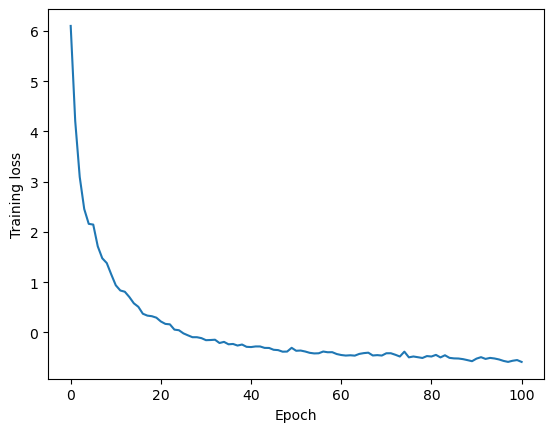

In [29]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

In [30]:
flow.save("data/ztfsniadr2_host_sn_pzflow.pkl")

In [31]:
flow = Flow(file="data/ztfsniadr2_host_sn_pzflow.pkl")

In [32]:
samples = flow.sample(100, seed=0)

<Axes: >

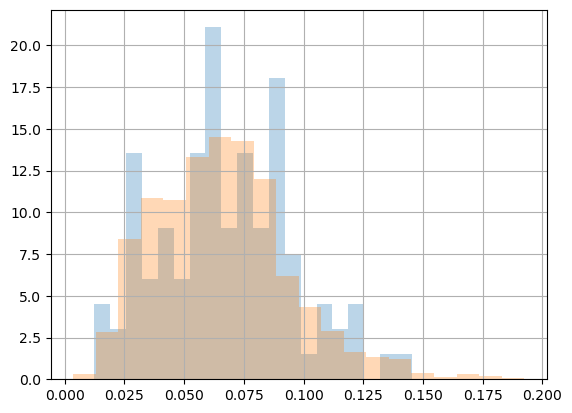

In [34]:
samples.redshift.hist(bins=20,alpha=0.3,density=True)
data_train.redshift.hist(bins=20,alpha=0.3,density=True)

<Axes: >

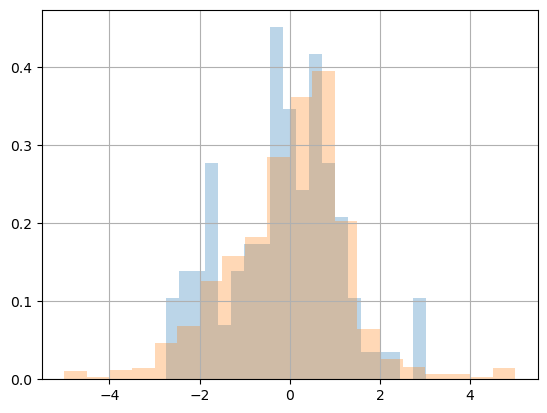

In [35]:
samples.x1.hist(bins=20,alpha=0.3,density=True)
data_train.x1.hist(bins=20,alpha=0.3,density=True)

<Axes: >

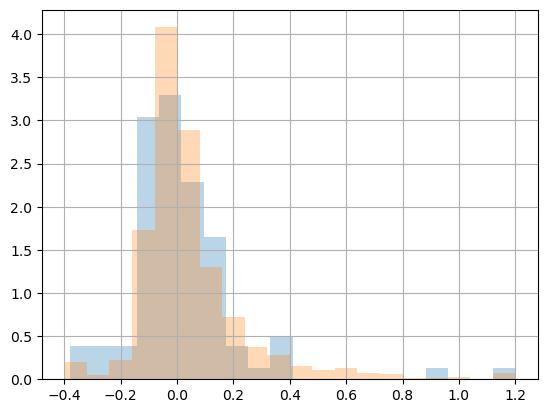

In [36]:
samples.c.hist(bins=20,alpha=0.3,density=True)
data_train.c.hist(bins=20,alpha=0.3,density=True)